In [1]:
import os
import glob
import numpy as np
import pandas as pd
import gym
from gym import spaces
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from scipy.optimize import minimize

def load_price_data(folder_pattern, start_date, end_date):
    files = glob.glob(folder_pattern)
    dfs = []
    for file in files:
        symbol = os.path.splitext(os.path.basename(file))[0]
        df = pd.read_csv(file, parse_dates=['Date'])
        mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
        df = df.loc[mask, ['Date', 'Adj Close']].set_index('Date')
        df.rename(columns={'Adj Close': symbol}, inplace=True)
        dfs.append(df)
    return pd.concat(dfs, axis=1).sort_index()


def load_sentiment(file_path, price_index, tickers):
    sent = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
    sent = sent.groupby(['date', 'stock'])['sentiment_score'].mean().unstack(fill_value=0)
    sent = sent.reindex(columns=tickers, fill_value=0)
    sent = sent.reindex(price_index, fill_value=0)
    return sent

class PortfolioEnv(gym.Env):
    """
    Custom Portfolio Environment for SB3 RecurrentPPO
    Observation: flattened array of [price_returns, sentiment, hist_log_returns]
    Action: portfolio weights across assets
    """
    metadata = {'render.modes': []}

    def __init__(self, price_df, sent_df=None, window_obs=60, window_state=120, lam=0.0):
        super().__init__()

        self.price_arr = price_df.values
        
        if sent_df is not None :
            self.sent_arr = sent_df.values
        else :
            self.sent_arr = None
            
        self.window_obs = window_obs    
        self.window_state = window_state
        self.n_assets = price_df.shape[1]
        self.lam = lam

        # observation: price_returns (window_obs-1 x n_assets) + sentiment (window_obs x n_assets) + hist (window_state)
        base_obs = (window_obs - 1) * self.n_assets + window_state
        if self.sent_arr is not None:
            base_obs += window_obs * self.n_assets
        obs_dim = base_obs

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # action: weight per asset, continuous
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_assets,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.step_idx = max(self.window_obs, self.window_state)
        self.port_val = 1.0
        self.history = [self.port_val]
        return self._get_obs()

    def step(self, action):
        assert action.shape[0] == self.n_assets
        # normalize weights
        weights = action / (np.sum(action) + 1e-8)

        p = self.price_arr[self.step_idx]
        p_next = self.price_arr[self.step_idx + 1]
        ret = (p_next / p) - 1
        raw_rew = np.dot(weights, ret)
        if self.lam and self.sent_arr is not None:
            s = np.dot(weights, self.sent_arr[self.step_idx])
            reward = raw_rew + self.lam * s
        else:
            reward = raw_rew

        self.port_val *= (1 + raw_rew)
        self.history.append(self.port_val)
        self.step_idx += 1
        done = self.step_idx >= len(self.price_arr) - 1

        obs = self._get_obs()
        return obs, reward, done, {}

    def _get_obs(self):
        i = self.step_idx
        # price returns window
        prices = self.price_arr[i-self.window_obs:i]
        price_ret = np.diff(prices, axis=0) / prices[:-1]
        if price_ret.shape[0] < self.window_obs - 1:
            pad = np.zeros(((self.window_obs-1) - price_ret.shape[0], self.n_assets))
            price_ret = np.vstack((pad, price_ret))

        # sentiment window
        
        if self.sent_arr is not None : 
            sent_win = self.sent_arr[i-self.window_obs:i].flatten()
        else :
            sent_win = []
            
        # history log returns
        hist = np.log(np.array(self.history[1:]) / np.array(self.history[:-1]))
        if len(hist) < self.window_state:
            hist = np.pad(hist, (self.window_state - len(hist), 0))
        else:
            hist = hist[-self.window_state:]
        # flatten all
        obs = np.concatenate([price_ret.flatten(), sent_win, hist], axis=0)
        return obs.astype(np.float32)

def calculate_mvo_weights(returns_df, risk_free_rate_daily=0.0):
    mu = returns_df.mean()
    Sigma = returns_df.cov()

    def neg_sharpe(w):
        p_ret = np.dot(w, mu)
        p_var = np.dot(w.T, np.dot(Sigma, w))
        p_vol = np.sqrt(p_var) if p_var > 0 else 0.0
        if p_vol == 0:
            return -np.inf if p_ret > risk_free_rate_daily else 0.0
        return -((p_ret - risk_free_rate_daily) / p_vol)

    n = len(mu)
    bounds = [(0,1)] * n
    cons = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1})
    init = np.ones(n) / n
    res = minimize(neg_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)
    if not res.success:
        print(f"MVO failed: {res.message}, using equal weights.")
        return init
    return res.x

def run_mvo_backtest(price_data_full, test_period_data, lookback_window=252):
    returns_full = price_data_full.pct_change().dropna()
    test_dates = test_period_data.index
    n_assets = test_period_data.shape[1]
    asset_names = test_period_data.columns

    weights_hist = pd.DataFrame(index=test_dates, columns=asset_names)
    port_rets = pd.Series(index=test_dates, dtype=float)

    for date in test_dates:
        idx = returns_full.index.get_loc(date)
        start_idx = idx - lookback_window
        if start_idx < 0:
            w = np.ones(n_assets) / n_assets
        else:
            hist = returns_full.iloc[start_idx:idx]
            if len(hist) < n_assets+1:
                w = np.ones(n_assets) / n_assets
            else:
                w = calculate_mvo_weights(hist)
        weights_hist.loc[date] = w
        port_rets.loc[date] = np.dot(w, returns_full.loc[date].fillna(0))

    return port_rets.dropna(), weights_hist

def run_rl_backtest_sb3(model, price_df, sent_df=None, window_obs=60, window_state=120, lam=0.0):
    env = PortfolioEnv(price_df.reset_index(drop=True), sent_df.reset_index(drop=True) if sent_df is not None else None, window_obs, window_state, lam)
    
    obs = env.reset()
    rets, dates = [], price_df.index[window_state+1:]
    lstm_states = None
    episode_start = True
    done = False
    while not done:
        action, lstm_states = model.predict(obs, state=lstm_states, episode_start=np.array([episode_start]), deterministic=True)
        obs, r, done, _ = env.step(action)
        # obs, r, done, _ = env.step(action[0])
        rets.append(r)
        episode_start = done
    return pd.Series(rets, index=dates[:len(rets)])

def calculate_performance_metrics(daily_returns, rf_annual=0.0):
    dr = daily_returns.fillna(0)
    cum = (1+dr).prod() - 1
    ann_ret = (1 + dr.mean())**252 - 1
    ann_vol = dr.std() * np.sqrt(252)
    rf_daily = (1 + rf_annual)**(1/252) - 1
    sr = (dr.mean() - rf_daily) / dr.std() * np.sqrt(252) if dr.std() > 0 else np.nan
    dd = (1+dr).cumprod()
    mxdd = (dd / dd.cummax() - 1).min()
    return pd.Series({'Cumulative Return': cum, 'Ann. Return': ann_ret, 'Ann. Vol': ann_vol, 'Sharpe': sr, 'Max DD': mxdd})


## Without sentiment

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- Testing 2016-01-01 : 2018-01-01 ---
                        MVO        RL
Cumulative Return  0.389456  0.442380
Ann. Return        0.247968  0.277424
Ann. Vol           0.095495  0.080306
Sharpe             2.320691  3.050404
Max DD            -0.111918 -0.052850


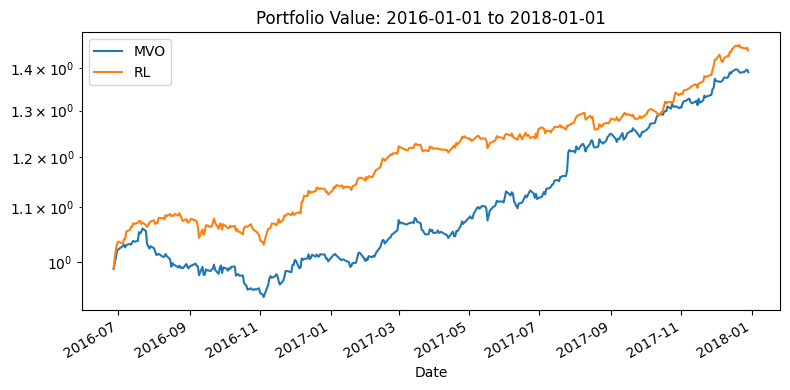


--- Testing 2018-01-01 : 2020-01-01 ---
                        MVO        RL
Cumulative Return  0.133055  0.361636
Ann. Return        0.099446  0.239708
Ann. Vol           0.157512  0.150181
Sharpe             0.602016  1.431390
Max DD            -0.170816 -0.172485


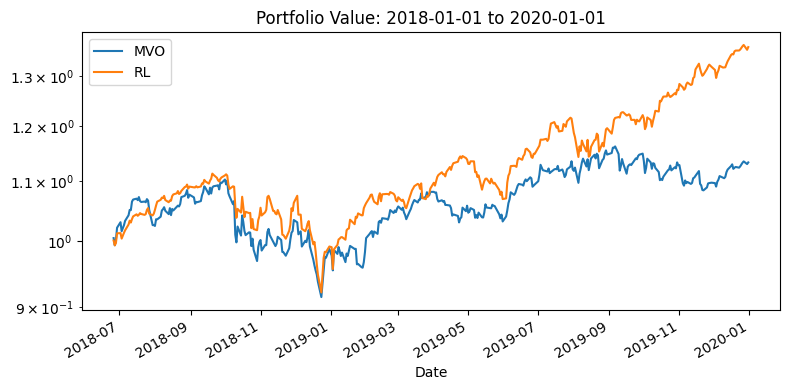


--- Testing 2020-01-01 : 2023-01-01 ---
                        MVO        RL
Cumulative Return  0.533761  0.419362
Ann. Return        0.220612  0.168977
Ann. Vol           0.239352  0.180440
Sharpe             0.833211  0.865536
Max DD            -0.203474 -0.252686


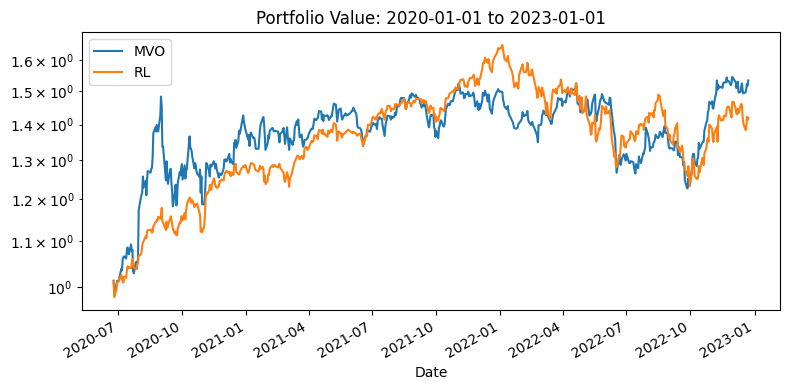

In [4]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize

folder_path = os.path.join("/teamspace/studios/this_studio/IFT6759_deep_portfolio/dj30/raw", "*.csv")
prices = load_price_data(folder_path, '2010-01-01', '2023-01-01')
tickers = prices.columns.tolist()
sens = load_sentiment("/teamspace/studios/this_studio/IFT6759_deep_portfolio/stocks_sentiment_scores.csv", prices.index, tickers)

train_p = prices.loc['2010-01-01':'2016-01-01']
# train_s = sens.loc[train_p.index]
train_s = None

def make_env(price_df, sent_df, window_obs, window_state, lam, seed=0):

    def _init():
        env = PortfolioEnv(price_df, sent_df, window_obs, window_state, lam)
        return env
    return _init

n_envs = 1
env_fns = [
    make_env(train_p, train_s, window_obs=60, window_state=120, lam=0.05)
    for i in range(n_envs)
]

env = SubprocVecEnv(env_fns)
env = VecNormalize(env)

# model = RecurrentPPO(
#     policy='MlpLstmPolicy',
#     env=env,
#     verbose=1,
#     tensorboard_log='./ppo_tensorboard/',
#     policy_kwargs={'lstm_hidden_size': 256},
# )
# model.learn(total_timesteps=300_000)
# model.save('recurrent_ppo_portfolio_without_sent_300')

# model = RecurrentPPO.load('recurrent_ppo_portfolio_300', env=env)
model = RecurrentPPO.load('recurrent_ppo_portfolio_without_sent_300', env=env)

# Test Periods comparison
test_periods = [
    ('2016-01-01', '2018-01-01'),
    ('2018-01-01', '2020-01-01'),
    ('2020-01-01', '2023-01-01'),
]

for start, end in test_periods:
    print(f"\n--- Testing {start} : {end} ---")
    test_p = prices.loc[start:end]
    # test_s = sens.loc[test_p.index]
    test_s = None

    mvo_rets, _ = run_mvo_backtest(prices, test_p)
    rl_rets = run_rl_backtest_sb3(model, test_p, test_s, window_obs=60, window_state=120, lam=0.05)

    idx = mvo_rets.index.intersection(rl_rets.index)
    mvo_r, rl_r = mvo_rets.loc[idx], rl_rets.loc[idx]
    mvo_m = calculate_performance_metrics(mvo_r)
    rl_m = calculate_performance_metrics(rl_r)
    comp = pd.DataFrame({'MVO': mvo_m, 'RL': rl_m})
    print(comp)

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    (1+mvo_r).cumprod().plot(label='MVO')
    (1+rl_r).cumprod().plot(label='RL')
    plt.title(f"Portfolio Value: {start} to {end}")
    plt.yscale('log'); plt.legend(); plt.tight_layout()
    plt.show()


## With sentiment

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- Testing 2016-01-01 : 2018-01-01 ---
                        MVO        RL
Cumulative Return  0.389456  0.465443
Ann. Return        0.247968  0.292762
Ann. Vol           0.095495  0.097049
Sharpe             2.320691  2.647243
Max DD            -0.111918 -0.045665


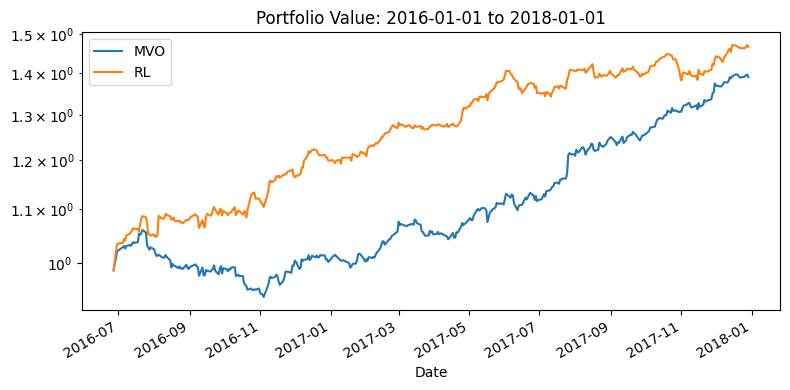


--- Testing 2018-01-01 : 2020-01-01 ---
                        MVO        RL
Cumulative Return  0.133055  0.519773
Ann. Return        0.099446  0.331913
Ann. Vol           0.157512  0.145143
Sharpe             0.602016  1.975844
Max DD            -0.170816 -0.111173


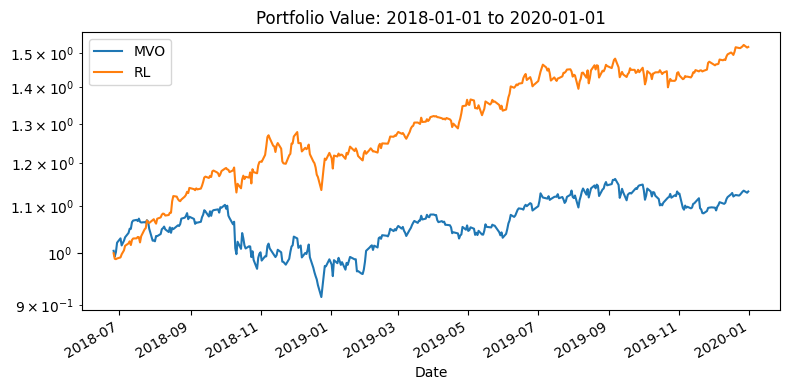


--- Testing 2020-01-01 : 2023-01-01 ---
                        MVO        RL
Cumulative Return  0.533761  0.960420
Ann. Return        0.220612  0.327790
Ann. Vol           0.239352  0.171617
Sharpe             0.833211  1.652956
Max DD            -0.203474 -0.164484


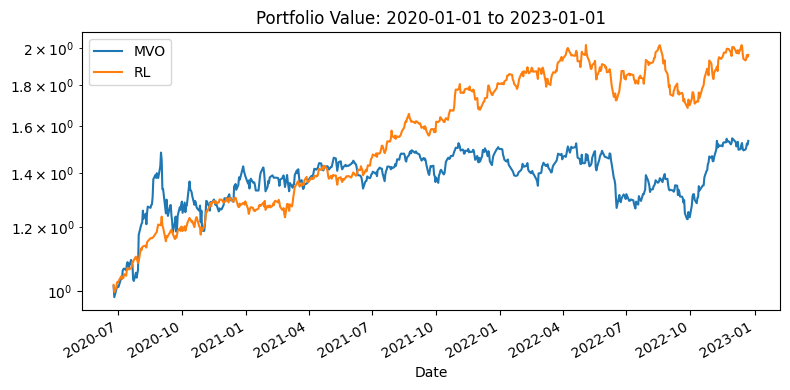

In [6]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize

folder_path = os.path.join("/teamspace/studios/this_studio/IFT6759_deep_portfolio/dj30/raw", "*.csv")
prices = load_price_data(folder_path, '2010-01-01', '2023-01-01')
tickers = prices.columns.tolist()
sens = load_sentiment("/teamspace/studios/this_studio/IFT6759_deep_portfolio/stocks_sentiment_scores.csv", prices.index, tickers)

train_p = prices.loc['2010-01-01':'2016-01-01']
train_s = sens.loc[train_p.index]

def make_env(price_df, sent_df, window_obs, window_state, lam, seed=0):

    def _init():
        env = PortfolioEnv(price_df, sent_df, window_obs, window_state, lam)
        return env
    return _init

n_envs = 1
env_fns = [
    make_env(train_p, train_s, window_obs=60, window_state=120, lam=0.05)
    for i in range(n_envs)
]

env = SubprocVecEnv(env_fns)
env = VecNormalize(env)

# model = RecurrentPPO(
#     policy='MlpLstmPolicy',
#     env=env,
#     verbose=1,
#     tensorboard_log='./ppo_tensorboard/',
#     policy_kwargs={'lstm_hidden_size': 256},
# )
# model.learn(total_timesteps=300_000)
# model.save('recurrent_ppo_portfolio_without_sent_300')

model = RecurrentPPO.load('recurrent_ppo_portfolio_300', env=env)
# model = RecurrentPPO.load('recurrent_ppo_portfolio_without_sent_300', env=env)

# Test Periods comparison
test_periods = [
    ('2016-01-01', '2018-01-01'),
    ('2018-01-01', '2020-01-01'),
    ('2020-01-01', '2023-01-01'),
]

for start, end in test_periods:
    print(f"\n--- Testing {start} : {end} ---")
    test_p = prices.loc[start:end]
    test_s = sens.loc[test_p.index]

    mvo_rets, _ = run_mvo_backtest(prices, test_p)
    rl_rets = run_rl_backtest_sb3(model, test_p, test_s, window_obs=60, window_state=120, lam=0.05)

    idx = mvo_rets.index.intersection(rl_rets.index)
    mvo_r, rl_r = mvo_rets.loc[idx], rl_rets.loc[idx]
    mvo_m = calculate_performance_metrics(mvo_r)
    rl_m = calculate_performance_metrics(rl_r)
    comp = pd.DataFrame({'MVO': mvo_m, 'RL': rl_m})
    print(comp)

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    (1+mvo_r).cumprod().plot(label='MVO')
    (1+rl_r).cumprod().plot(label='RL')
    plt.title(f"Portfolio Value: {start} to {end}")
    plt.yscale('log'); plt.legend(); plt.tight_layout()
    plt.show()
